# FV3-CHEM in MONET

FV3-CHEM is the experimental implementation of the NASA Gocart model into NOAA's Next Generation Global Prediction System.  This tutorial will explain how to open read and use MONET to explore output from the FV3-CHEM system. 

Currently, FV3 outputs data in three formats, i.e., nemsio, grib2, and netcdf.  There are slight issues with both the nemsio and grib2 data that will be explained below but needless to say they need to be converted with precossors.  

## MONET on WCOSS

MONET can be used currently on WCOSS Phase 1, and WCOSS Phase 2.  MONET will not be installed on WCOSS Cray but there are plans to move to WCOSS Phase 3 in the near future.  To use the python environment that MONET is installed on users much do a few things.  

### Create .condarc 

First, a `.condarc` file needs to be created and placed in the `HOME` directory.  To create this please copy the following and place in the file named `.condarc` :

```
channels:
  - conda-forge
  - defaults
envs_dirs:
  - /naqfc/noscrub/Barry.Baker/python/envs
pkgs_dirs:
  - /naqfc/noscrub//Barry.Baker/python/pkgs  
```
  
### Activate MONET Environment
  
The MONET python environment can then be loaded and sourced.  It is recommended that in the current shell that other modules be purged so that conflicts between packages do not raise.  

``` 

module purge

```

Next, use and load the modules:

```

module use -a /gpfs/hps3/emc/naqfc/save/Barry.Baker/modulefiles
module load anaconda/latest

```

and then activate the MONET environment:

```
source activate monet
```

You can put this all in a bash script that you can source when wanting to use MONET:

```bash

#!/bin/bash                                                                                                                                                                    

module purge

module use -a /gpfs/hps3/emc/naqfc/save/Barry.Baker/modulefiles
module load anaconda/latest

source activate monet

```

## Convert nemsio2nc4

The first format that needs to be converted is the nemsio data.  This is a binary format used within EMC that is planned to be phased out in favor for netCDF.  As a work around a converter was created to convert the binary nemsio data into netCDF, nemsio2nc4.py. 

This is a command-line script that converts the nemsio data output by the FV3 system to netcdf4 files using a combination of mkgfsnemsioctl found within the fv3 workflow and the climate data operators (cdo). This tool is available on github at https://github.com/bbakernoaa/nemsio2nc4

```
nemsio2nc4.py --help
usage: nemsio2nc4.py [-h] -f FILES [-n NPROCS] [-v]

convert nemsio file to netCDF4 file

optional arguments:
  -h, --help            show this help message and exit
  -f FILES, --files FILES
                        input nemsio file name (default: None)
  -v, --verbose         print debugging information (default: False)
```
  
### Example Usage

If you want to convert a single nemsio data file to netcdf4, it can be done like this:

```
nemsio2nc4.py -v -f 'gfs.t00z.atmf000.nemsio'
mkgfsnemsioctl: /gpfs/hps3/emc/naqfc/noscrub/Barry.Baker/FV3CHEM/exec/mkgfsnemsioctl
cdo: /naqfc/noscrub/Barry.Baker/python/envs/monet/bin/cdo
Executing: /gpfs/hps3/emc/naqfc/noscrub/Barry.Baker/FV3CHEM/exec/mkgfsnemsioctl gfs.t00z.atmf000.nemsio
Executing: /naqfc/noscrub/Barry.Baker/python/envs/monet/bin/cdo -f nc4 import_binary gfs.t00z.atmf000.nemsio.ctl gfs.t00z.atmf000.nemsio.nc4
cdo import_binary: Processed 35 variables [1.56s 152MB]
```

To convert multiple files you can simple use the hot keys available in linux terminals.

```
 nemsio2nc4.py -v -f 'gfs.t00z.atmf0*.nemsio'
```


## Convert fv3grib2nc4

Although there are several ways in which to read grib data from python such as pynio, a converter was created due to the specific need to distinguish aerosols which these readers do not process well. 


fv3grib2nc4.py like nemsio2nc4.py tool is a command line tool created to convert the grib2 aerosol data to netcdf files.  fv3grib2nc4.py will create seperate files for each of the three layer types; '1 hybrid layer', 'entire atmosphere', and 'surface'.  These are the three layers that currently hold aerosol data. The tool is available at https://github.com/bbakernoaa/fv3grib2nc4

```
fv3grib2nc4.py --help
usage: fv3grib2nc4.py [-h] -f FILES [-v]

convert nemsio file to netCDF4 file

optional arguments:
  -h, --help            show this help message and exit
  -f FILES, --files FILES
                        input nemsio file name (default: None)
  -v, --verbose         print debugging information (default: False) ```

### Example Usage

If you want to convert a single grib2 data file to netcdf4, it can be done like this:

```
fv3grib2nc4.py -v -f 'gfs.t00z.master.grb2f000'
wgrib2: /nwprod2/grib_util.v1.0.0/exec/wgrib2
Executing: /nwprod2/grib_util.v1.0.0/exec/wgrib2 gfs.t00z.master.grb2f000 -match "entire atmosphere:" -nc_nlev 1 -append -set_ext_name 1 -netcdf gfs.t00z.master.grb2f000.entire_atm.nc
Executing: /nwprod2/grib_util.v1.0.0/exec/wgrib2 gfs.t00z.master.grb2f000 -match "1 hybrid level:" -append -set_ext_name 1 -netcdf gfs.t00z.master.grb2f000.hybrid.nc
Executing: /nwprod2/grib_util.v1.0.0/exec/wgrib2 gfs.t00z.master.grb2f000 -match "surface:" -nc_nlev 1 -append -set_ext_name 1 -netcdf gfs.t00z.master.grb2f000.surface.nc```

To convert multiple files you can simple use the hot keys available in linux terminals.

```
 fv3grib2nc4.py -v -f 'gfs.t00z.master.grb2f0*'
```
 
## Using MONET

Using MONET with FV3-Chem is much like using MONET with other model outputs.  It tries to recognize where the files came from (nemsio, grib2, etc....) and then processes the data, renaming coordinates (lat lon to latitude and longitude) and processing varaibles like geopotential height and pressure if available.  First lets import `monet` and `fv3chem` from MONET



In [1]:
import matplotlib.pyplot as plt
from monet.models import fv3chem

To open a single file 

In [24]:
f = fv3chem.open_dataset('/Users/barry/Desktop/temp/gfs.t00z.atmf006.nemsio.nc4')
print(f)

<xarray.Dataset>
Dimensions:    (time: 1, x: 384, y: 192, z: 64)
Coordinates:
  * time       (time) datetime64[ns] 2018-07-01
  * x          (x) float64 0.0 0.9375 1.875 2.812 ... 356.2 357.2 358.1 359.1
  * y          (y) float64 89.28 88.36 87.42 86.49 ... -87.42 -88.36 -89.28
  * z          (z) float64 1.0 2.0 3.0 4.0 5.0 6.0 ... 60.0 61.0 62.0 63.0 64.0
    longitude  (y, x) float64 0.0 0.9375 1.875 2.812 ... 356.2 357.2 358.1 359.1
    latitude   (y, x) float64 89.28 89.28 89.28 89.28 ... -89.28 -89.28 -89.28
Data variables:
    ugrd       (time, z, y, x) float32 ...
    vgrd       (time, z, y, x) float32 ...
    dzdt       (time, z, y, x) float32 ...
    delz       (time, z, y, x) float32 ...
    tmp        (time, z, y, x) float32 ...
    dpres      (time, z, y, x) float32 536.92773 536.92255 ... 44.247 44.246998
    spfh       (time, z, y, x) float32 ...
    clwmr      (time, z, y, x) float32 ...
    rwmr       (time, z, y, x) float32 ...
    icmr       (time, z, y, x) float32 .

Notice this object f has dimensions of (time,z,y,x) with 2d coordinates of latitude and longitude. You can get more infomation on single varaibles such as pm25 simply by printing the varaible. 

In [4]:
print(f.pm25)

<xarray.DataArray 'pm25' (time: 1, z: 64, y: 192, x: 384)>
[4718592 values with dtype=float32]
Coordinates:
  * time       (time) datetime64[ns] 2018-07-01
  * x          (x) float64 0.0 0.9375 1.875 2.812 ... 356.2 357.2 358.1 359.1
  * y          (y) float64 89.28 88.36 87.42 86.49 ... -87.42 -88.36 -89.28
  * z          (z) float64 1.0 2.0 3.0 4.0 5.0 6.0 ... 60.0 61.0 62.0 63.0 64.0
    longitude  (y, x) float64 0.0 0.9375 1.875 2.812 ... 356.2 357.2 358.1 359.1
    latitude   (y, x) float64 89.28 89.28 89.28 89.28 ... -89.28 -89.28 -89.28
Attributes:
    long_name:  model layer


Here units are not included because it is not stored in the nemsio format.  

### Quick Map Plotting

Now one of the main things that will need to be done is plotting on a map.  This can be done quickly using the functionallity in MONET. In this example we will plot the first layer PM2.5 at time 2018-07-01.   

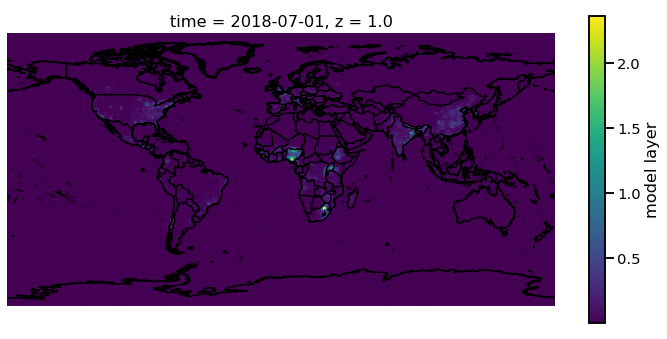

In [5]:
f.pm25[0,0,:,:].monet.quick_map()

Adjusting the scale is simple by suppling `vmin` and `vmax`.  Lets set a minimum of 0 AOD and maximum of 0.5.  

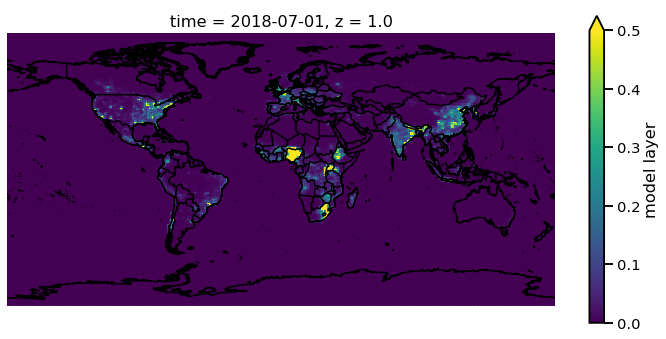

In [6]:
f.pm25[0,0,:,:].monet.quick_map(vmin=0,vmax=.5)

Now we have all the control that xarray has built into their plotting routines.  For example, lets have a descrete colorbar with 10 levels, `levels=10`, and let it determine the levels by throwing out the top and bottom 2% of values using the `robust=True`

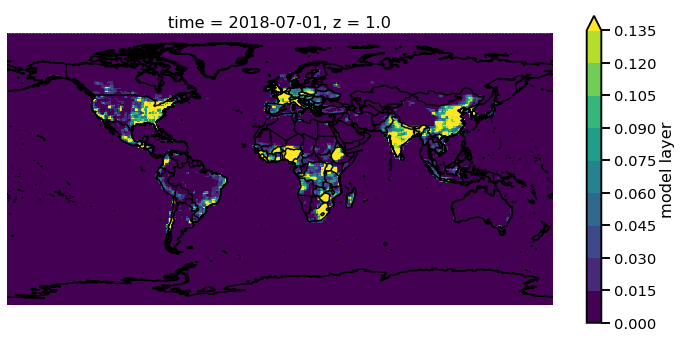

In [7]:
f.pm25[0,0,:,:].monet.quick_map(levels=10,robust=True)

Now there are a lot of very low values, since this is at the beginning of the simulation so lets mask out values less than 0.015 AOD.  

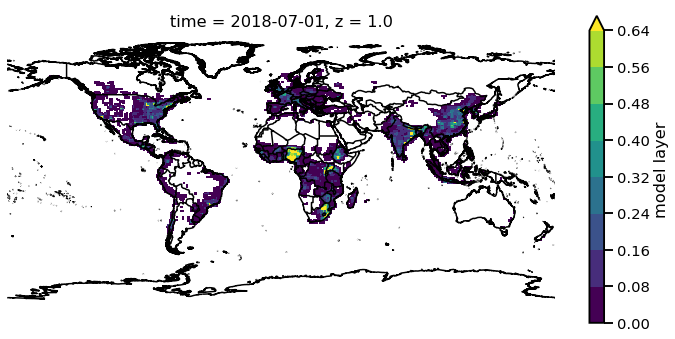

In [8]:
f.pm25.where(f.pm25 > 0.015)[0,0,:,:].monet.quick_map(levels=10,robust=True)

For more information on plotting with xarray and matplotlib some useful links are shown below

- [Xarray Plotting](http://xarray.pydata.org/en/stable/plotting.html#two-dimensions)
- [Matplotlib Colorbars](https://matplotlib.org/tutorials/colors/colormaps.html)



### Nearest neighbor

Monet has some extra functionality that may be useful for exploritory studies such as nearest neighbor finder.  Lets find the nearest neighbor to NCWCP (38.972 N, 76.9245 W).  

In [9]:
nn = f.pm25.monet.nearest_latlon(lat=38.972,lon=-76.9245)
print(nn)

Create weight file: monet_xesmf_regrid_file.nc
Overwrite existing file: monet_xesmf_regrid_file.nc 
 You can set reuse_weights=True to save computing time.
Remove file monet_xesmf_regrid_file.nc
<xarray.DataArray 'pm25' (z: 64)>
array([5.360318e-01, 3.792825e-01, 2.377463e-01, 1.332659e-01, 5.727730e-02,
       2.083287e-02, 6.091245e-03, 1.443858e-03, 3.188324e-04, 1.198079e-04,
       9.345255e-05, 9.057471e-05, 9.048021e-05, 9.048422e-05, 9.048710e-05,
       9.047858e-05, 9.047571e-05, 9.047643e-05, 9.048853e-05, 9.048565e-05,
       9.048233e-05, 9.048278e-05, 9.048375e-05, 9.048294e-05, 9.048243e-05,
       9.048294e-05, 9.048338e-05, 9.048596e-05, 9.048430e-05, 9.048299e-05,
       9.048199e-05, 9.048250e-05, 9.048302e-05, 9.048319e-05, 9.048475e-05,
       9.048442e-05, 9.048307e-05, 9.048300e-05, 9.048275e-05, 9.048315e-05,
       9.048282e-05, 9.048314e-05, 9.048325e-05, 9.048280e-05, 9.048348e-05,
       9.048296e-05, 9.048288e-05, 9.048266e-05, 9.048266e-05, 9.048268e-05,
 

Now we can do a quick plot of this vertically, since it was a single time step. 

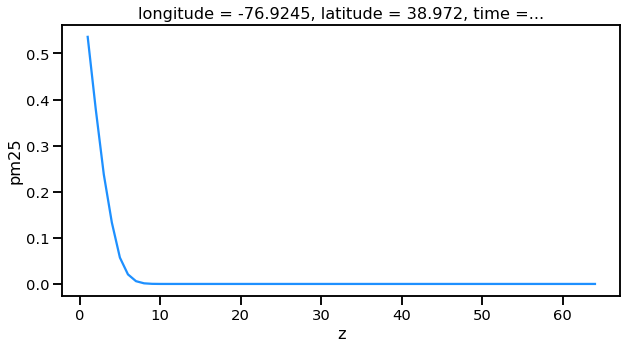

In [11]:
nn.plot(aspect=2,size=5)

Now this is a simple plot but it is usually valuable to view the vertical coordinate on the y-axis.  

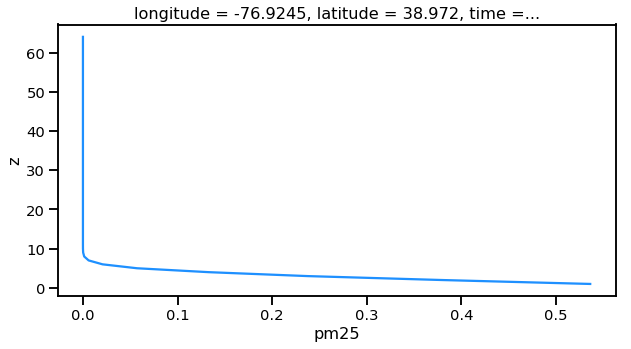

In [12]:
nn.plot(y='z',aspect=2,size=5)

Now this is not very useful because the vertical coordinate right now is just the layer number.  Lets get the geopoential height at this location and add it as a coordinate to plot.

In [13]:
# nn['geohgt']= f.geohgt.monet.nearest_latlon(lat=38.972,lon=-76.9245)
# nn.plot(y='z',aspect=2,size=5)
# from matplotlib.pyplot import *
# ylim([0,2000])
geohgt = f.geohgt.monet.nearest_latlon(lat=38.972,lon=-76.9245)
geohgt

Create weight file: monet_xesmf_regrid_file.nc
Overwrite existing file: monet_xesmf_regrid_file.nc 
 You can set reuse_weights=True to save computing time.
Remove file monet_xesmf_regrid_file.nc


<xarray.DataArray 'geohgt' (z: 64)>
array([  142.29006 ,   291.280994,   447.847933,   612.93705 ,   787.572251,
         972.901864,  1170.125815,  1380.589313,  1605.757127,  1847.213012,
        2106.643259,  2385.86942 ,  2686.82763 ,  3011.117315,  3360.498532,
        3736.934345,  4142.499136,  4578.190698,  5043.976683,  5540.515765,
        6069.323374,  6629.896353,  7220.182094,  7840.337875,  8492.631454,
        9173.72607 ,  9882.930796, 10617.262252, 11371.849584, 12143.780825,
       12929.977534, 13727.087343, 14533.051271, 15345.267905, 16163.117259,
       16985.63724 , 17810.482429, 18638.26789 , 19471.321652, 20319.38806 ,
       21188.872107, 22080.233274, 22995.270321, 23936.541907, 24899.187727,
       25882.293229, 26889.376598, 27922.722714, 28985.4569  , 30080.057902,
       31209.971081, 32381.47682 , 33603.069826, 34883.983199, 36237.265007,
       37683.244583, 39247.735096, 40970.280218, 42919.334275, 45195.309154,
       47994.95128 , 51753.502712, 57685

In [2]:
nn['z'] = geohgt.values
nn.plot(y='z')
plt.ylim([0,3000])

NameError: name 'geohgt' is not defined

### Constant Latitude and Longitude

Sometimes it may be useful to see a latitudinal or longitudinal cross section.  This feature is included in monet through the `xr.DataArray.monet` accessor.  Lets take a constant latitude at 10 degrees N.  


In [40]:
pm25_constant_lat = f.pm25.monet.interp_constant_lat(lat=10., method='bilinear')
pm25_constant_lat

Overwrite existing file: bilinear_192x384_192x1.nc 
 You can set reuse_weights=True to save computing time.


<xarray.DataArray 'pm25' (time: 1, z: 64, x: 192, y: 1)>
array([[[[8.107865e-02],
         ...,
         [4.765707e-02]],

        ...,

        [[9.984020e-05],
         ...,
         [9.982444e-05]]]])
Coordinates:
    longitude  (x, y) float64 0.0 1.88 3.76 5.64 ... 353.4 355.3 357.2 359.1
    latitude   (x, y) float64 10.0 10.0 10.0 10.0 10.0 ... 10.0 10.0 10.0 10.0
  * time       (time) datetime64[ns] 2018-07-01
  * z          (z) float64 1.0 2.0 3.0 4.0 5.0 6.0 ... 60.0 61.0 62.0 63.0 64.0
Dimensions without coordinates: x, y
Attributes:
    regrid_method:  bilinear

Like before lets go ahead and get the geopotential height along this latitude.

In [41]:
geoght_constant_lat = f.geohgt.monet.interp_constant_lat(lat=10., method='bilinear')
pm25_constant_lat['geohgt'] = geoght_constant_lat

Overwrite existing file: bilinear_192x384_192x1.nc 
 You can set reuse_weights=True to save computing time.


Let us plot the 2D cross track (height vs longitude).

(0, 50000)

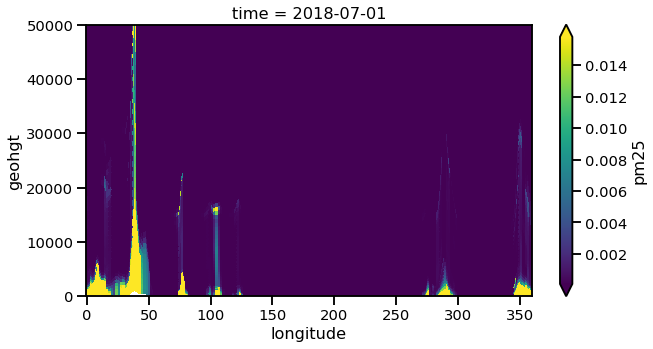

In [48]:
pm25_constant_lat.plot(x='longitude',y='geohgt',robust=True,ylim=1000,aspect=2,size=5)
plt.ylim([0,50000])